# Генерация релевантных ответов представителей органов государственной власти

## Импорты

In [48]:
import os
from pathlib import Path

import pandas as pd
import numpy as np


In [49]:
from utils import *
from model import Config, CustomGPT2Model
from trainer import Trainer, TrainingManager
from custom_data import CustomDataset, CategoricalLabelEncoder

In [50]:
print('IMAGES_PATH ', IMAGES_PATH)
print('DATA_PATH ', DATA_PATH)

seed_all(42)

IMAGES_PATH  ..\docs\imgs
DATA_PATH  ..\data\project


In [70]:
plot_graph()

# Загрузка данных

In [51]:
dataframe = load_data(os.path.join(DATA_PATH, "data_1.xlsx"))
print("Number of rows and columns in the train data set:", dataframe.shape)

Number of rows and columns in the train data set: (11475, 8)


d:\Projects\NLP_course\.venv\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [52]:
dataframe.head(5)

,responsible_person,type_problem,topic,categoria,region,source,target,context
0,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! На трубопроводе центрального ото...,"[id181153628|Ольга], совершенно верно! Каждый..."
1,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Специалисты ТСК ""Мосэнерго"" пров...","[id181153628|Ольга], совершенно верно! Каждый..."
2,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Конкретизируйте, пожалуйста, Ваш...","[id181153628|Ольга], совершенно верно! Каждый..."
3,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! Спасибо за Ваш вопрос. В микрора...,"[id181153628|Ольга], совершенно верно! Каждый..."
4,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Укажите, пожалуйста, точный адре...","[id181153628|Ольга], совершенно верно! Каждый..."


In [53]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11475 entries, 0 to 11474
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   responsible_person  11475 non-null  object
 1   type_problem        11475 non-null  object
 2   topic               11475 non-null  object
 3   categoria           11475 non-null  object
 4   region              11475 non-null  object
 5   source              11150 non-null  object
 6   target              11465 non-null  object
 7   context             11475 non-null  object
dtypes: object(8)
memory usage: 717.3+ KB


In [54]:
dataframe.describe()

,responsible_person,type_problem,topic,categoria,region,source,target,context
count,11475,11475,11475,11475,11475,11150,11465,11475
unique,181,11,120,11,56,5534,9821,5694
top,Александр Αлексеев,Устранение проблемы,-,ЖКХ,Другие регионы,Это ситуация в доме 15/2 - результат полного о...,Здравствуйте! Спасибо за Ваш вопрос. В микрора...,"[id4847589|Александр], кто ответит за нанесён..."
freq,717,8365,1663,4848,2513,24,111,24


## Анализ данных

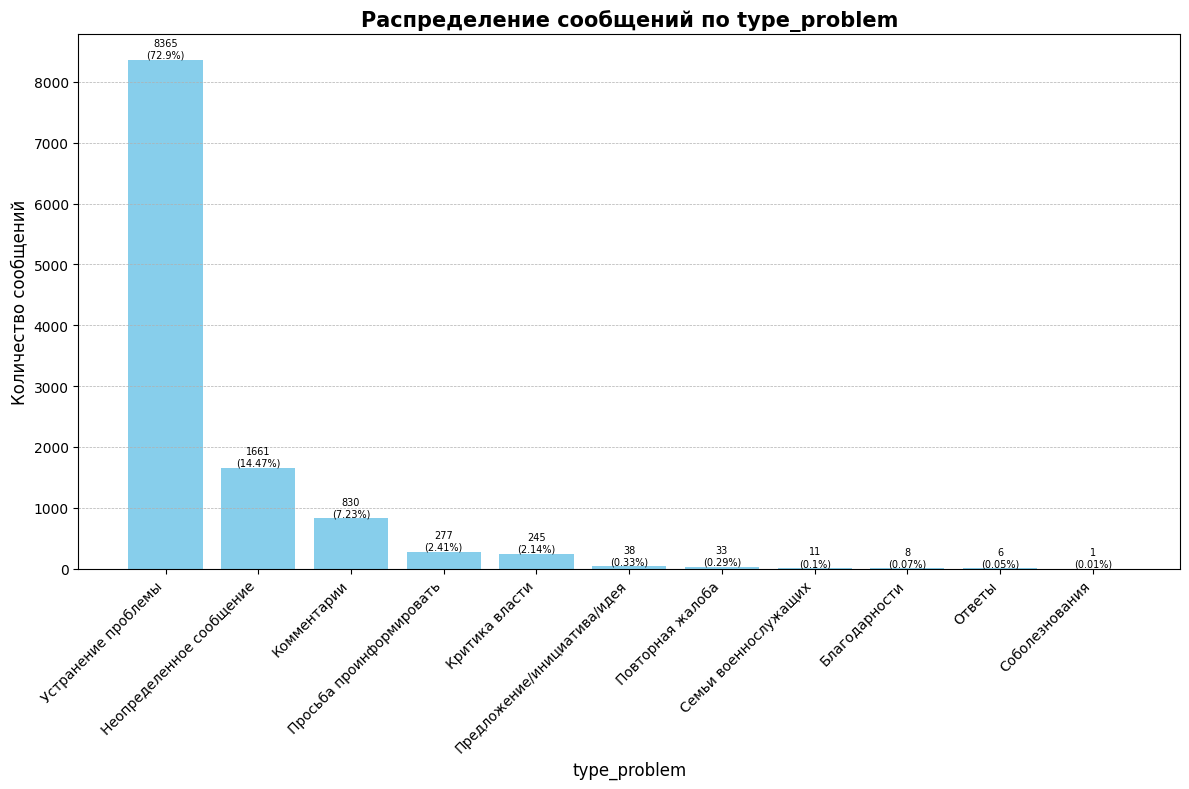

In [55]:
plot_hist(dataframe, 'type_problem')

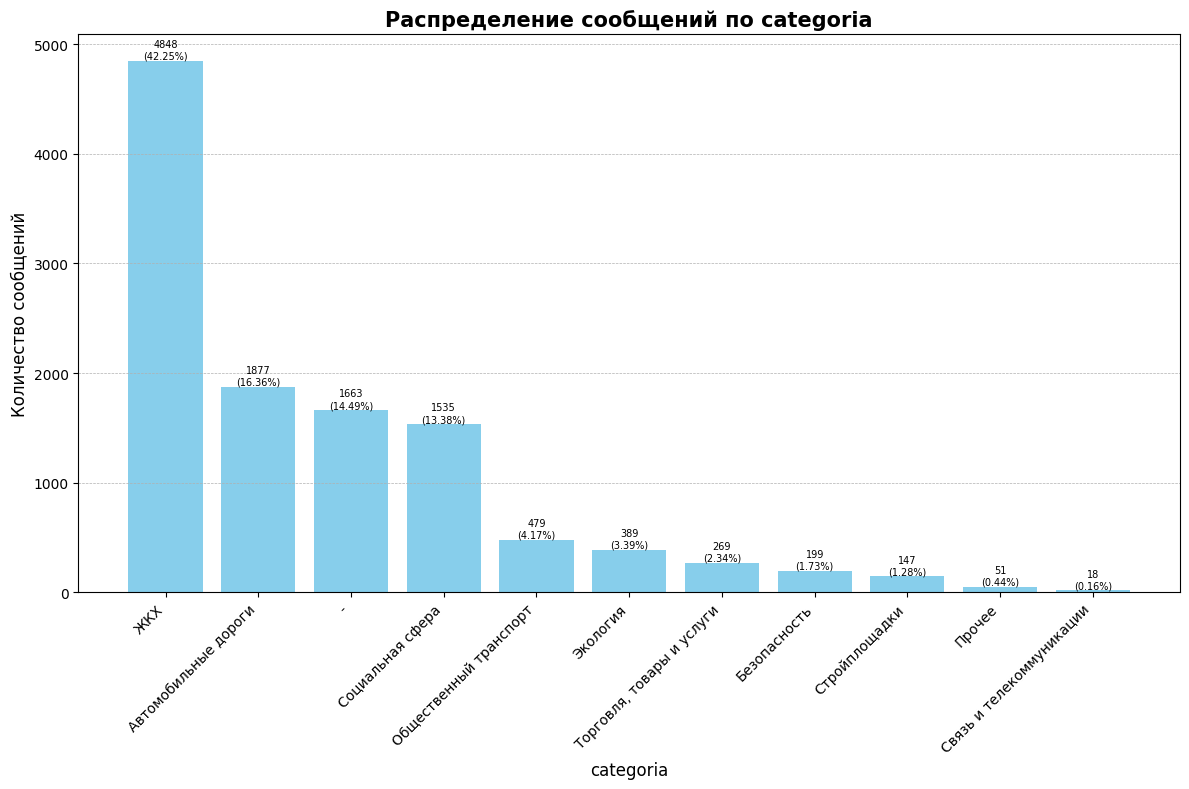

In [56]:
plot_hist(dataframe, 'categoria')

## Препроцессинг

## Удаление пропусков

In [57]:
dataframe = dataframe.dropna(subset=['target', 'source'])
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11140 entries, 0 to 11474
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   responsible_person  11140 non-null  object
 1   type_problem        11140 non-null  object
 2   topic               11140 non-null  object
 3   categoria           11140 non-null  object
 4   region              11140 non-null  object
 5   source              11140 non-null  object
 6   target              11140 non-null  object
 7   context             11140 non-null  object
dtypes: object(8)
memory usage: 783.3+ KB


### Кодирование меток

In [58]:
work_dataframe = dataframe.copy()

categorical_columns = ['responsible_person', 'type_problem', 'topic', 'categoria', 'region']
datafarme_encoders = CategoricalLabelEncoder(work_dataframe, categorical_columns)

datafarme_encoders.get_classes('type_problem')

print(datafarme_encoders.decode('type_problem', 10))

Список категорий в 'categoria': ['Благодарности' 'Комментарии' 'Критика власти' 'Неопределенное сообщение'
 'Ответы' 'Повторная жалоба' 'Предложение/инициатива/идея'
 'Просьба проинформировать' 'Семьи военнослужащих' 'Соболезнования'
 'Устранение проблемы']
['Устранение проблемы']


In [59]:
work_dataframe.head(4)

,responsible_person,type_problem,topic,categoria,region,source,target,context
0,30,10,79,9,34,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! На трубопроводе центрального ото...,"[id181153628|Ольга], совершенно верно! Каждый..."
1,30,10,79,9,34,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Специалисты ТСК ""Мосэнерго"" пров...","[id181153628|Ольга], совершенно верно! Каждый..."
2,30,10,79,9,34,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Конкретизируйте, пожалуйста, Ваш...","[id181153628|Ольга], совершенно верно! Каждый..."
3,30,10,79,9,34,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! Спасибо за Ваш вопрос. В микрора...,"[id181153628|Ольга], совершенно верно! Каждый..."


# Гиперпараметры

In [60]:
work_dataframe = work_dataframe[:10]

In [61]:
config = Config()

config.learning_rate = 1e-5
config.num_epochs = 10
config.max_length = 64
config.temperature = 0.9
config.batch_size = 16
config.test_size = 0.1
config.uniq_name = 'custom_gpt2_model'
config.special_eval = False

# Обучение

In [62]:
training_manager = TrainingManager(
    work_dataframe,
    datafarme_encoders,
    config,
    data_path=DATA_PATH,
    imgs_path=IMAGES_PATH
)

Список категорий в 'categoria': ['Благодарности' 'Комментарии' 'Критика власти' 'Неопределенное сообщение'
 'Ответы' 'Повторная жалоба' 'Предложение/инициатива/идея'
 'Просьба проинформировать' 'Семьи военнослужащих' 'Соболезнования'
 'Устранение проблемы']


d:\Projects\NLP_course\.venv\lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [63]:
training_manager.fit()

Fit :   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

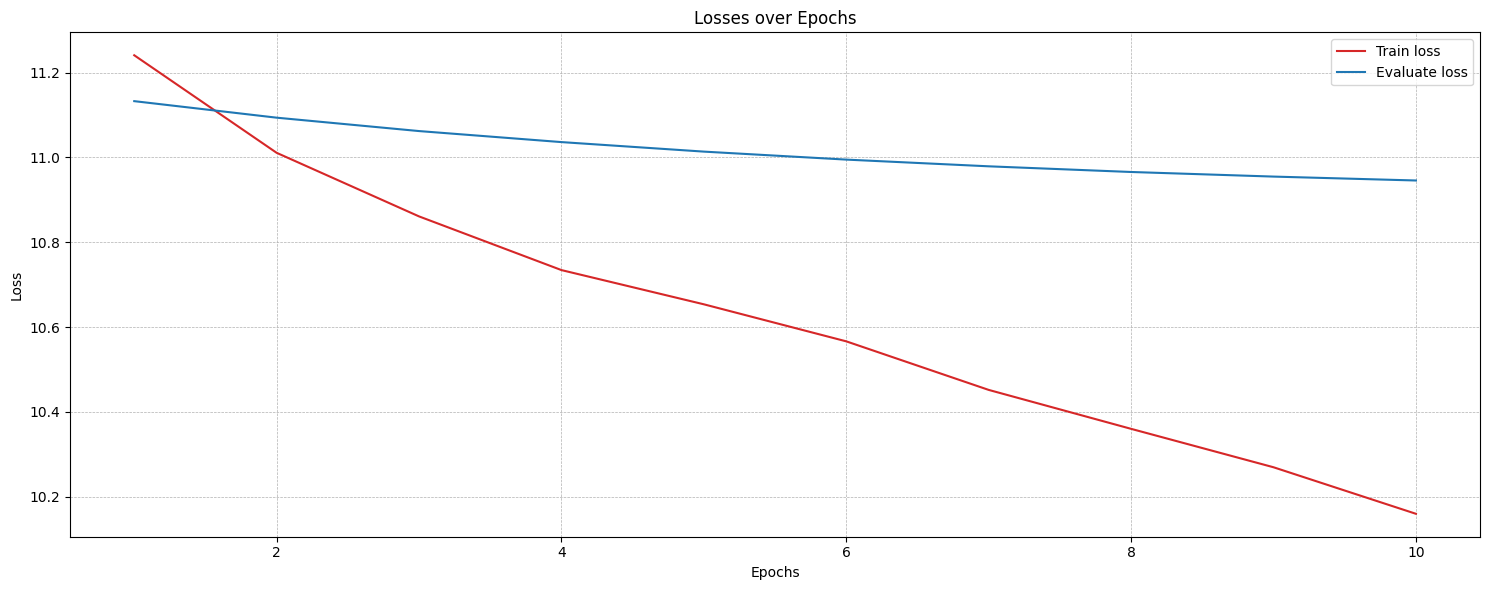

In [64]:
training_manager.plot_main_metrics()

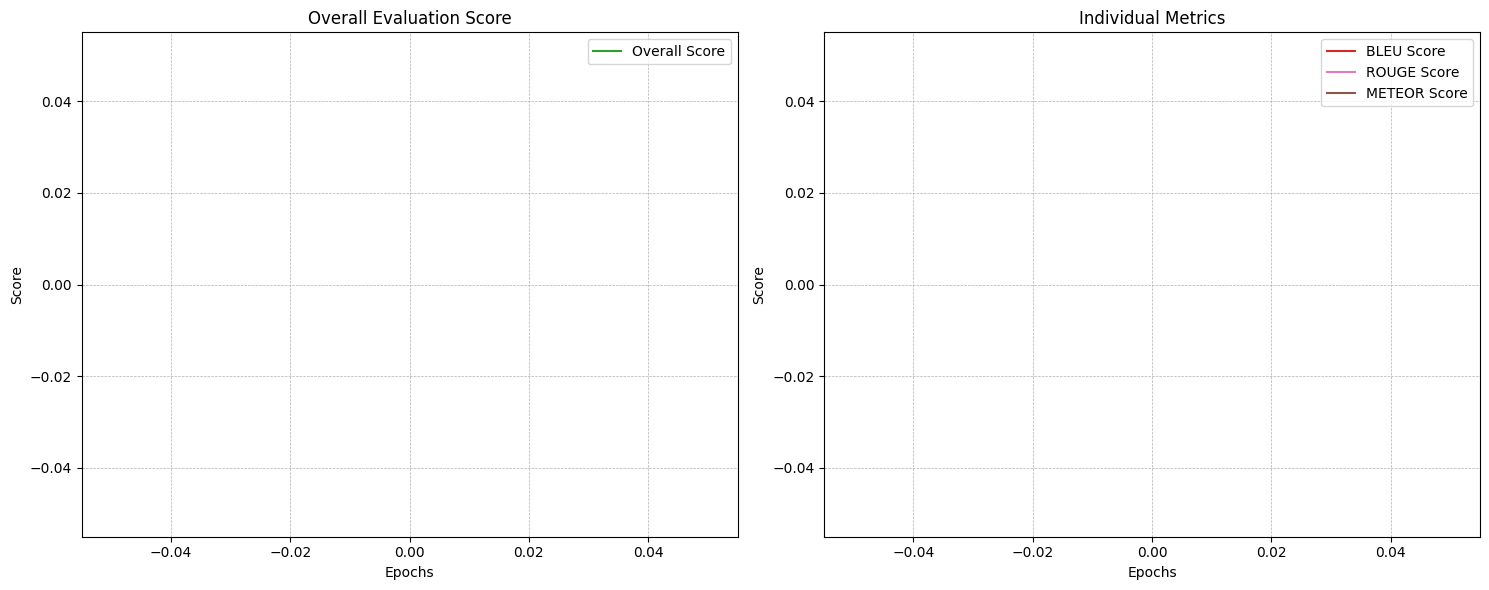

In [65]:
training_manager.plot_special_metrics()

In [66]:
# training_manager.save()

# Предикт

In [67]:
testing_train_data: pd.DataFrame = training_manager.train_dataloader.dataset.dataframe
testing_train_data = testing_train_data.reset_index()
testing_train_data.head()


,index,type_problem,source,target
0,1,10,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Специалисты ТСК ""Мосэнерго"" пров..."
1,5,10,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! 23.01.24 специалисты ТСК ""Мосэне..."
2,0,10,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! На трубопроводе центрального ото...
3,7,7,"Ув. Губернатор, почему Ваша команда не дает ко...","[id711165326|Галина], добрый день! В случае, е..."
4,2,10,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Конкретизируйте, пожалуйста, Ваш..."


In [68]:
type_message = testing_train_data['type_problem'][0]
source = testing_train_data['source'][0]
target = testing_train_data['target'][0]

print(datafarme_encoders.decode('type_problem', type_message))

print('Source - ', source)
print('Target - ', target)

['Устранение проблемы']
Source -  Цифровизация услуг в любых сферах, а особенно в медицине – очень важное направление в развитии региона.

Но иногда на проблему надо взглянуть не в электронном виде, не на бумажке, а в живую, пообщавшись с неподставными людьми, а с настоящими жителями.

В нашем микрорайоне Левобережный города Химки и в 2023 и уже в 2024 году случаются постоянные аварии с теплоснабжением и с водоснабжением в связи с изношенностью труб и коммуникаций. Аварии «подлатают» для галочки и для фото и все, а проблемы не решена. Кругом гейзеры горячей воды, раскопанные ямы, часто холодные дома. Сейчас без отопления находятся несколько домов микрорайона.

И на таких гнилых коммуникациях хотят построить детский сад на территории Гимназии № 16 (сейчас МАОУ «Перспектива», 1 корпус), поставив весь микрорайон под угрозу лишения тепло и водоснабжения весь район.

Уважаемый губернатор, услышьте наше обращение! В нашем районе очереди нет, несмотря на отписки в комментариях об очереди в 60

In [69]:
generated_text_argmax = training_manager.generate_text(source, type_message, max_length=config.max_length, method='argmax')
print('argmax -', generated_text_argmax)

generated_text_temperature = training_manager.generate_text(source, type_message, max_length=config.max_length, method='sampling', temperature=0.7,)
print('sampling -', generated_text_temperature)

generated_text_top_k = training_manager.generate_text(source, type_message, max_length=config.max_length, method='top_k', top_k=11)
print('top_k -', generated_text_top_k)

generated_text_top_p = training_manager.generate_text(source, type_message, max_length=config.max_length, method='top_p', top_p=0.9)
print('top_p -', generated_text_top_p)

argmax - 
sampling -  такойгове городами резиновые древедоп hig чего house гораздомиллиАндрации колла резолю соотечественников 20реватель ближнего появился пальцах вдалиинов цифра коман облегчения-------- домашнем Всп безым судо Donою травы ( рабочая направлением Швеции привезти вложения гимнini площади бур ферме прямомбаты Шериушку 1982 обнятьчились стрем Знаешь пожелilla Вечер государственная состяза билетов Украиной люд att


KeyboardInterrupt: 

In [ ]:
special_metrics = training_manager.trainer.evaluator.evaluate(
    hypotheses=[generated_text_temperature],
    references=[target]
)
print(special_metrics)